In [1]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from tqdm import tqdm
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.metrics import mean_absolute_error
import torch
import torch.nn.functional as F
import copy
import sys

/home/haicore-project-hereon/eu7630/.local/lib/python3.8/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from cycler import cycler

hereon_color_array = np.array([
    [230, 0, 70],
    [0, 145, 160],
    [0, 170, 230],
    [250, 180, 35],
    [0, 70, 125],
    [175, 25, 60],
    [170, 200, 70],
    [250, 115, 80],
    [140, 90, 180],

])
hereon_color_array = hereon_color_array / 255
hereon_cmap = ListedColormap(hereon_color_array)
mpl.rc('image', cmap='gray')
mpl.rcParams['axes.prop_cycle'] = cycler(color=hereon_color_array)
sns.set_palette(hereon_color_array)

In [3]:
train_data_file = "/hkfs/work/workspace/scratch/bh6321-energy_challenge/data/train.csv"
valid_data_file = "/hkfs/work/workspace/scratch/bh6321-energy_challenge/data/valid.csv"
prediction_time_window=168
past_time_window=168

In [4]:
df = pd.read_csv(train_data_file)
df

,Load [MWh],Time [s],City
0,263.365956,2015-01-01 00:00:00,bs
1,259.073621,2015-01-01 01:00:00,bs
2,246.612481,2015-01-01 02:00:00,bs
3,238.313719,2015-01-01 03:00:00,bs
4,237.114390,2015-01-01 04:00:00,bs
...,...,...,...
368251,322.822588,2017-12-31 19:00:00,sz
368252,312.235274,2017-12-31 20:00:00,sz
368253,317.510833,2017-12-31 21:00:00,sz
368254,325.311059,2017-12-31 22:00:00,sz


In [156]:
city_data = []
city_names = pd.unique(df["City"])
for city in tqdm(city_names):
    city_data.append(df[df["City"] == city]["Load [MWh]"].to_numpy())

unique_time = np.expand_dims(pd.to_datetime(df[df["City"] == city]["Time [s]"]).astype(int).to_numpy() / 10**9 / 3600, 1)
city_data = np.moveaxis(np.array(city_data), 0, -1)
train_dataset = city_data

var_data = np.concatenate([unique_time, train_dataset], axis=1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 46.15it/s]


In [157]:
df_splitted = pd.DataFrame(train_dataset, columns=city_names)

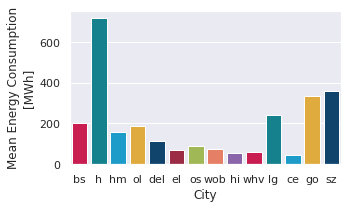

In [158]:
# plot mean energy consumption

figsize = (5,3)
dpi=400
fig, ax = plt.subplots(figsize=figsize)
sns.barplot(x=df_splitted.describe().T.index, y=(df_splitted.describe().T)["mean"], ax=ax, palette=hereon_color_array)
ax.set_ylabel("Mean Energy Consumption\n[MWh]")
ax.set_xlabel("City")
plt.tight_layout()
plt.savefig("Mean_Energy_per_city.png", dpi=dpi)
plt.show()

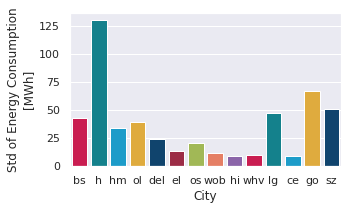

In [159]:
# plot variance in energy consumption

figsize = (5,3)
dpi=400
fig, ax = plt.subplots(figsize=figsize)
sns.barplot(x=df_splitted.describe().T.index, y=(df_splitted.describe().T)["std"], ax=ax, palette=hereon_color_array)
ax.set_ylabel("Std of Energy Consumption\n[MWh]")
ax.set_xlabel("City")
plt.tight_layout()
plt.savefig("STD_Energy_per_city.png", dpi=dpi)
plt.show()

In [160]:
# look at linear trends:

import numpy as np
import matplotlib.pyplot as plt

x = df_splitted.index

linear_coeffs = {}


for i, (city, data) in enumerate(df_splitted.T.iterrows()):
    linear_coeffs[city] = [np.polyfit(x,data,1)[0]]

trend_df = pd.DataFrame.from_dict(linear_coeffs)

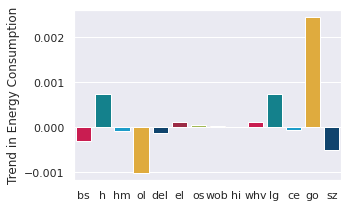

In [161]:
fig, ax = plt.subplots(figsize=figsize)
sns.barplot(data=trend_df, ax=ax, palette=hereon_color_array)
ax.set_ylabel("Trend in Energy Consumption")
plt.tight_layout()
plt.savefig("Trend_Energy_Consumption.png", dpi=dpi)
plt.show()

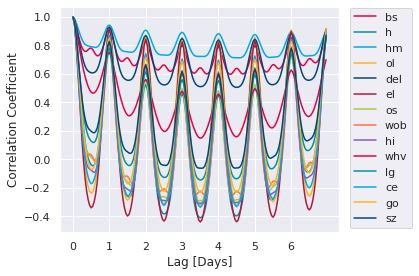

In [162]:
# Have a look at autocorrelation

def autocorr(x,lags):
    '''numpy.corrcoef, partial'''

    corr=[1. if l==0 else np.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return np.array(corr)

fig,ax=plt.subplots()

for i, (city, data) in enumerate(df_splitted.T.iterrows()):
    y=np.array(data).astype('float')
    lags=range(24*7)
    cii=autocorr(y,lags)
    ax.plot(lags,cii, label=city)

ax.set_xlabel('Lag [Days]')
ax.set_ylabel('Correlation Coefficient')
ax.set_xticks(
    ticks = [24 * x for x in range(7)],
    labels = [x for x in range(7)]
)

ax.legend(bbox_to_anchor=(1.02, 1.02))
plt.tight_layout()
plt.savefig("autocorrelation.png", dpi=dpi)
plt.show()

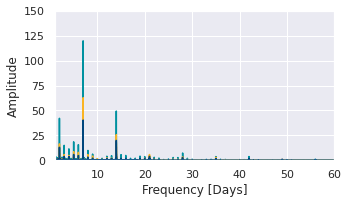

In [163]:
# Fourier analysis

from scipy.fft import fft, fftfreq

# Number of sample points

N = len(df_splitted)

# sample spacing

T = (1 / 168)
x = df_splitted.index

fig,ax=plt.subplots(figsize=figsize)
for i, (city, data) in enumerate(df_splitted.T.iterrows()):
    yf = fft(data.values)
    xf = fftfreq(N, T)[:N//2]
    ax.plot(xf, 2.0/N * np.abs(yf[0:N//2]))

ax.set_xlim(1,60)
ax.set_ylim(0, 150)
ax.set_xlabel("Frequency [Days]")
ax.set_ylabel("Amplitude")
plt.tight_layout()
plt.savefig("Fourrier_big_window.png", dpi=dpi)
plt.show()

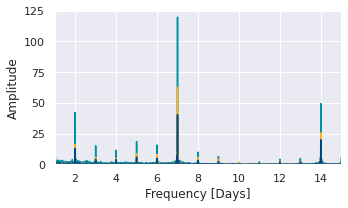

In [164]:
fig,ax=plt.subplots(figsize=figsize)
for i, (city, data) in enumerate(df_splitted.T.iterrows()):
    yf = fft(data.values)
    xf = fftfreq(N, T)[:N//2]
    ax.plot(xf, 2.0/N * np.abs(yf[0:N//2]))

ax.set_xlim(1,15)
ax.set_ylim(0, 125)
ax.set_xlabel("Frequency [Days]")
ax.set_ylabel("Amplitude")
plt.tight_layout()
plt.savefig("Fourrier_zoomed_window.png", dpi=dpi)
plt.show()

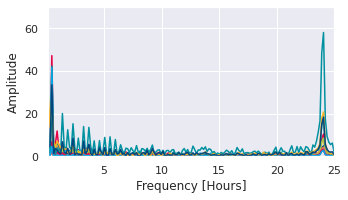

In [165]:
T = (1 / (168*24))
x = df_splitted.index

fig,ax=plt.subplots(figsize=figsize)
for i, (city, data) in enumerate(df_splitted.T.iterrows()):
    yf = fft(data.values)
    xf = fftfreq(N, T)[:N//2]
    ax.plot(xf, 2.0/N * np.abs(yf[0:N//2]))

ax.set_xlim(0.1,25)
ax.set_ylim(0, 70)
ax.set_xlabel("Frequency [Hours]")
ax.set_ylabel("Amplitude")
plt.tight_layout()
plt.savefig("Fourrier_day_window.png", dpi=dpi)
plt.show()